In [1]:
!nvidia-smi

Thu Jun  2 05:18:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
import os
import numpy as np
import pandas as pd
from glob import glob
from natsort import natsorted

In [3]:
!unzip -qq /content/drive/MyDrive/4-1_Capstone/CapstoneDataset/images_concatenate.zip -d /content/capstone_images
capstone_images = natsorted(glob(os.path.join("/content/capstone_images", '*')))

In [4]:
capstone_label_df = pd.read_csv("/content/drive/MyDrive/4-1_Capstone/CapstoneDataset/Capstone_labels.csv")

In [5]:
SAMPLES = 500
os.system("unzip -qq /content/drive/MyDrive/4-1_Capstone/AI_HubDataset/images" + str(SAMPLES) + ".zip -d /content/aihub_images")
aihub_images = natsorted(glob(os.path.join("/content/aihub_images/images" + str(SAMPLES), '*')))

In [6]:
aihub_label_df = pd.read_csv("/content/aihub_images/AI_Label_" + str(SAMPLES)  +".csv")

In [8]:
images = capstone_images + aihub_images
label_df = pd.concat([capstone_label_df, aihub_label_df]).fillna(0.).reset_index(drop = True)

In [9]:
# train_test_split
argmax_classes = []
for label in label_df.values:
    if label.sum() == 1:    argmax_classes.append(label.argmax())
    else:                   argmax_classes.append(4) # 3과 4가 동시에 존재하면 4 데이터가 적으므로 4에 포함시킴

# # len(argmax_classes)
# from sklearn.model_selection import train_test_split
# train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

# train_images = np.array(images)[train_i]
# val_images   = np.array(images)[val_i]

# train_y = label_df.values[train_i]
# val_y   = label_df.values[val_i]

In [23]:
from torch.utils.data import Dataset
from PIL import Image

class MyDataset(Dataset):

    def __init__(self, dataset_info, transform=None, split=None):        
        
        self.split = split
        self.transform = transform

        self.img_dirs, self.y = dataset_info

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):        
        image = Image.open(self.img_dirs[idx])
        image = image.convert('RGB')
        
        y = self.y[idx]

        image = self.transform(image)

        return image, y

import torchvision.transforms as T
!pip install timm -q
import timm
from timm.data.constants import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD

tf = T.Compose([
    # T.Resize(256, interpolation=3),
    # T.CenterCrop(224),
    T.Resize(224, interpolation=3),
    T.ToTensor(),
    # T.RandomRotation(degrees=(-180, 180)),
    # T.RandomHorizontalFlip(p=0.5),
    # T.RandomVerticalFlip(p=0.5), # Rotation을 넣는 순간 Flip은 한개만 수행하면 되며, H-Flip이 V-Flip보다 빠르다.
    # T.ColorJitter(brightness=.5, contrast=.5),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD),
])


In [12]:
%cd /content/drive/MyDrive/4-1_Capstone
from utils import get_crop_mask

crop_mask = get_crop_mask()
crop_mask = torch.Tensor(crop_mask).cuda()
crop_mask

/content/drive/MyDrive/4-1_Capstone


tensor([[1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        [1., 1., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 1., 0., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 0., 1.]], device='cuda:0')

In [13]:
%cd /content/drive/MyDrive/4-1_Capstone
from class_balanced_loss import CB_loss
from collections import Counter
samples_per_cls = list(map(float, (Counter(sorted(argmax_classes)).values())))
no_of_classes = len(label_df.columns)
loss_type = "focal" # in [sigmoid, softmax, focal]
beta = 0.9999 # usaually in 0.9, 0.99, 0.999, 0.9999
gamma = 2.0

/content/drive/MyDrive/4-1_Capstone


In [39]:
!pip install timm -q
N_CLASSES = len(label_df.columns)
import torch
import timm
from PIL import Image
import requests
import matplotlib.pyplot as plt
import torchvision
%config InlineBackend.figure_format = 'retina'

from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import f1_score

!pip install wandb -qqq
import wandb
wandb.login(key="9086993130a56abc5cd780b691a69c2618757f73")

device = 'cuda' if torch.cuda.is_available() else 'cpu'

def calc_macro_f1(preds, GT):
    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)    
    return f1_score(GT, preds_sigmoid, average = 'macro', zero_division = 0)

# method
def train(model, epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, dataset_info = None):
    nb_epochs = epoch

    model = model.to(device)
    # optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, nesterov=True)
    # optimizer = torch.optim.RMSprop(model.parameters(), lr=lr)
    if      optimizer == 'AdamW':
        optimizer = torch.optim.AdamW(model.parameters(), lr=lr)
    elif    optimizer == 'RMSprop':
        optimizer = torch.optim.RMSProp(model.parameters(), lr=lr)
    else:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    criterion = torch.nn.BCEWithLogitsLoss().to(device)

    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4, nb_epochs*2//4, nb_epochs*3//4], gamma=0.5)
    # scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[nb_epochs//4], gamma=0.1)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=3)       

    train_info, val_info = dataset_info

    train_loader = DataLoader(MyDataset(train_info, tf, split='TRAIN'),
                            batch_size=batch_size,
                            shuffle=True,
                            # drop_last=True,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)


    validation_loader = DataLoader(MyDataset(val_info, tf, split='VALIDATION'),
                            batch_size=batch_size,
                            shuffle=False,
                            drop_last=False,
                            pin_memory=True,
                            num_workers=4)

    import warnings
    warnings.filterwarnings('ignore')

    train_losses = []
    val_losses = []
    train_macro_f1 = []
    val_macro_f1 = []
    from tqdm import tqdm
    for epoch in tqdm(range(nb_epochs)):

        losses = 0
        preds = []                
        model.train()
        for X, Y in train_loader:
            X = X.to(device)
            Y = Y.to(device)
            
            H = model(X)    
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
            # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
            preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
            loss = criterion(H, Y)        
            losses += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()            
        train_loss = losses / len(train_info[1])
        train_losses.append(train_loss)
        
        train_f1 = calc_macro_f1(preds, train_info[1])
        train_macro_f1.append(train_f1)

        scheduler.step()
        # print("train_loss = ", train_loss)

        losses = 0
        preds = []                
        model.eval()
        with torch.no_grad():
            for X, Y in validation_loader:
                X = X.to(device)
                Y = Y.to(device)

                H = model(X)
                H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)
                # loss = CB_loss(Y, H, samples_per_cls, no_of_classes, loss_type, beta, gamma).to(device)
                preds.extend(((H>0).detach().cpu().numpy() * 1).tolist())
                loss = criterion(H, Y)

                losses += loss.item()
        val_loss = losses / len(val_info[1])
        val_losses.append(val_loss)
        # print("val_loss = ", val_loss)

        val_f1 = calc_macro_f1(preds, val_info[1])
        val_macro_f1.append(val_f1)

        print(f"EPOCH {epoch} : TRAIN_LOSS = {train_loss:.4f}  VAL_LOSS = {val_loss:.4f}  TRAIN_F1 = {train_f1:.3f} VAL_F1 = {val_f1:.3f}")
        # 🐝 2️⃣ Log metrics from your script to W&B
        wandb.log({"train-loss": train_loss, "validation-loss": val_loss, "train-f1": train_f1, "val-f1": val_f1})

    # Mark the run as finished
    wandb.finish()

    import matplotlib.pyplot as plt
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='train')
    plt.plot(val_losses, label='val')
    plt.title('Loss')

    plt.subplot(1, 2, 2)
    plt.plot(train_macro_f1, label='train')
    plt.plot(val_macro_f1, label='val')
    plt.title('macro_f1')
    plt.legend()

    plt.show()


def test(model, val_dataset_info, batch_size = 32):

    test_loader = DataLoader(MyDataset(val_dataset_info, tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_dataset_info[1], preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

def preds_analysis(preds):
    preds = np.array(preds)

    from collections import Counter
    import matplotlib.pyplot as plt
    for cls in range(len(label_df.columns)):
        plt.figure(figsize=(20,3))
        Actual_y = cls
        x = [str(n) for n in range(len(label_df.columns))]
        y = (preds[val_y[:, Actual_y] == 1] > 0).astype(int).sum(0)

        plt.bar(x, y)
        plt.title(f"Actual_y = {Actual_y}")

        for i in range(len(y)):
            plt.annotate(y[i], (x[i], y[i]), ha = 'center', va = 'bottom')

        plt.show()

from sklearn.model_selection import StratifiedKFold

sfk = StratifiedKFold(n_splits=5)

K_train_x = []
K_test_x = []

K_train_y = []
K_test_y = []

for train_idx , test_idx in sfk.split(images , np.array(argmax_classes)):
    print(train_idx)
    K_train_x_i = np.array(images)[train_idx]
    K_test_x_i = np.array(images)[test_idx]

    K_train_y_i  = label_df.values[train_idx, :]
    K_test_y_i  = label_df.values[test_idx, :]

    K_train_x.append(K_train_x_i)
    K_test_x.append(K_test_x_i)

    K_train_y.append(K_train_y_i)
    K_test_y.append(K_test_y_i)
    
def run_K_fold(model = 'E', epoch = 10, batch_size = 32, optimizer = 'AdamW', lr = 1e-3, memo=None, K = 5):

    architecture = 'EfficientNet_B0' if model == 'E' else 'DeiT'

    for k in range(K):
        # 🐝 1️⃣ Start a new run to track this script
        wandb.init(
            # Set the project where this run will be logged
            project="debug",
            # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
            name = f"{memo}_{k}", 
            # Track hyperparameters and run metadata
            config={
            "architecture": architecture,
            "epochs": epoch,
            "optimizer": optimizer,
            "learning_rate": lr,
            })
        
        from torch.nn import Linear
        N_CLASSES = 72
        if model == 'E':
            model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
            model.classifier = Linear(in_features=1280, out_features=N_CLASSES, bias=True)

        if model == 'D':
            model = torch.hub.load('facebookresearch/deit:main', 'deit_base_patch16_224', pretrained=True)
            model.head = Linear(in_features=768, out_features=N_CLASSES, bias=True)
        
        train_dataset_info = (K_train_x[k], K_train_y[k])
        val_dataset_info = (K_test_x[k], K_test_y[k])
        dataset_info = (train_dataset_info, val_dataset_info)

        train(model, epoch, batch_size, optimizer, lr, dataset_info)
        preds = test(model, val_dataset_info)
        torch.save(model.state_dict(), f"/content/{k}th_model.pth")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


[  605   606   607 ... 43982 43983 43984]
[    0     1     2 ... 43982 43983 43984]
[    0     1     2 ... 43982 43983 43984]
[    0     1     2 ... 43982 43983 43984]
[    0     1     2 ... 43743 43744 43745]


# 1. EfficientNet B0

 10%|█         | 1/10 [02:46<24:58, 166.47s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0209  TRAIN_F1 = 0.015 VAL_F1 = 0.881


Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 232, in _feed
    close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
 20%|██        | 2/10 [05:23<21:27, 160.89s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0209  TRAIN_F1 = 0.014 VAL_F1 = 0.884


 30%|███       | 3/10 [08:00<18:33, 159.11s/it]

EPOCH 2 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0209  TRAIN_F1 = 0.013 VAL_F1 = 0.903


 40%|████      | 4/10 [10:37<15:49, 158.24s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0208  TRAIN_F1 = 0.015 VAL_F1 = 0.879


 50%|█████     | 5/10 [13:12<13:06, 157.26s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0209  TRAIN_F1 = 0.013 VAL_F1 = 0.903


 60%|██████    | 6/10 [15:50<10:29, 157.32s/it]

EPOCH 5 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0209  TRAIN_F1 = 0.014 VAL_F1 = 0.907


 70%|███████   | 7/10 [18:26<07:51, 157.03s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0209  TRAIN_F1 = 0.014 VAL_F1 = 0.893


 80%|████████  | 8/10 [21:04<05:14, 157.20s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0209  TRAIN_F1 = 0.014 VAL_F1 = 0.900


 90%|█████████ | 9/10 [23:40<02:36, 156.90s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0209  TRAIN_F1 = 0.013 VAL_F1 = 0.910


100%|██████████| 10/10 [26:16<00:00, 157.69s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0209  TRAIN_F1 = 0.014 VAL_F1 = 0.896


train-f1,█▄▃█▁▄▅▆▂▅
train-loss,█▃▂▅▂▁▄▂▁▃
val-f1,▁▂▆▁▆▇▄▆█▅
validation-loss,▆█▅▁▇▃▆▇▄▃
train-f1,0.01398
train-loss,0.02057
val-f1,0.89577
validation-loss,0.02086


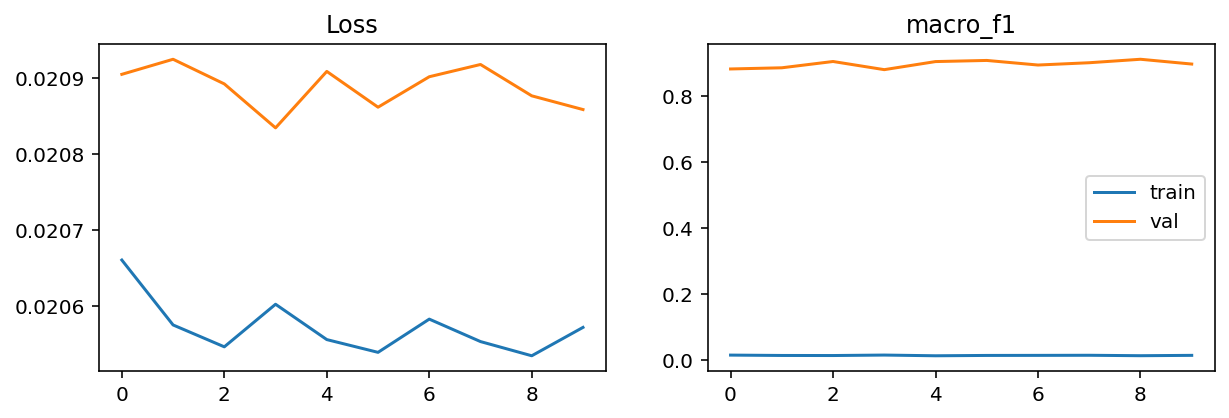

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       605
           1       0.90      0.93      0.92       111
           2       0.94      0.92      0.93       249
           3       0.93      0.99      0.96       556
           4       0.85      0.88      0.87        52
           5       0.97      1.00      0.99       335
           6       0.55      0.90      0.68       218
           7       0.92      0.31      0.46       239
           8       0.74      0.97      0.84       331
           9       1.00      1.00      1.00       289
          10       0.99      1.00      1.00       113
          11       0.98      0.53      0.69       226
          12       0.97      0.99      0.98       100
          13       0.97      0.98      0.98        65
          14       0.98      0.99      0.99       100
          15       0.92      1.00      0.96       100
          16       0.98      1.00      0.99       100
          17       0.98    

 10%|█         | 1/10 [02:35<23:22, 155.82s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.957


 20%|██        | 2/10 [05:11<20:46, 155.79s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.968


 30%|███       | 3/10 [07:48<18:14, 156.41s/it]

EPOCH 2 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.014 VAL_F1 = 0.982


 40%|████      | 4/10 [10:25<15:38, 156.46s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.962


 50%|█████     | 5/10 [13:02<13:04, 156.85s/it]

EPOCH 4 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.963


 60%|██████    | 6/10 [15:39<10:26, 156.65s/it]

EPOCH 5 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.971


 70%|███████   | 7/10 [18:16<07:51, 157.00s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.957


 80%|████████  | 8/10 [20:52<05:13, 156.57s/it]

EPOCH 7 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.970


 90%|█████████ | 9/10 [23:28<02:36, 156.33s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.969


100%|██████████| 10/10 [26:04<00:00, 156.45s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.958


train-f1,▄▃▃▅▄▅▆█▆▁
train-loss,█▄▂▇▃▁▆▃▁▅
val-f1,▁▄█▂▃▅▁▅▄▁
validation-loss,▄▄▁▇▅▃█▄▄█
train-f1,0.01337
train-loss,0.02056
val-f1,0.95781
validation-loss,0.0206


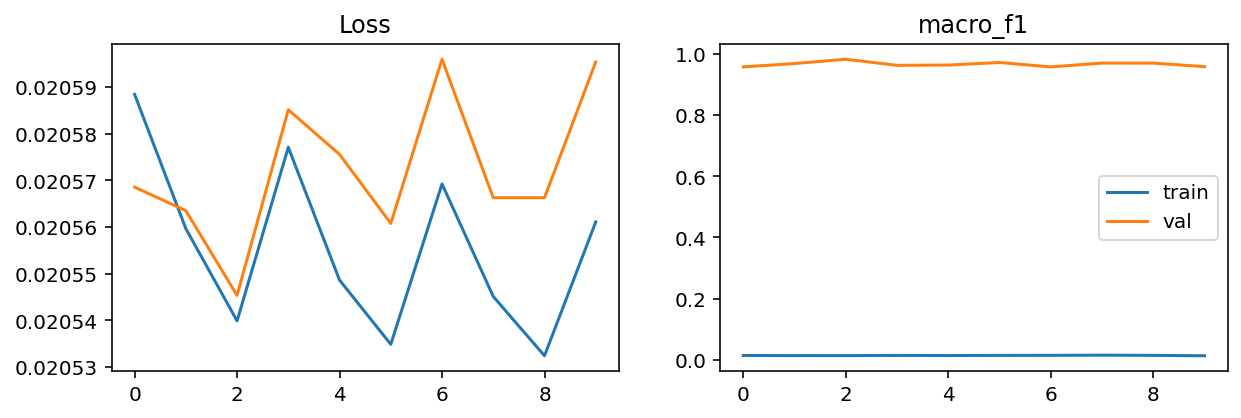

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       0.92      0.98      0.95       111
           2       1.00      0.96      0.98       249
           3       0.92      1.00      0.96       556
           4       1.00      0.63      0.78        52
           5       1.00      1.00      1.00       335
           6       0.96      0.97      0.97       218
           7       0.97      0.94      0.96       239
           8       0.92      0.99      0.96       331
           9       1.00      1.00      1.00       289
          10       1.00      1.00      1.00       113
          11       0.97      0.89      0.93       226
          12       1.00      1.00      1.00       100
          13       1.00      0.98      0.99        65
          14       0.97      0.97      0.97       100
          15       0.93      1.00      0.97       100
          16       1.00      0.98      0.99       100
          17       1.00    

 10%|█         | 1/10 [02:36<23:25, 156.12s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.983


 20%|██        | 2/10 [05:13<20:52, 156.62s/it]

EPOCH 1 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.014 VAL_F1 = 0.988


 30%|███       | 3/10 [07:49<18:15, 156.44s/it]

EPOCH 2 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.015 VAL_F1 = 0.991


 40%|████      | 4/10 [10:26<15:39, 156.65s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.976


 50%|█████     | 5/10 [13:02<13:02, 156.42s/it]

EPOCH 4 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.981


 60%|██████    | 6/10 [15:38<10:25, 156.33s/it]

EPOCH 5 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.982


 70%|███████   | 7/10 [18:15<07:49, 156.55s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.969


 80%|████████  | 8/10 [20:51<05:12, 156.41s/it]

EPOCH 7 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.978


 90%|█████████ | 9/10 [23:28<02:36, 156.67s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.978


100%|██████████| 10/10 [26:05<00:00, 156.54s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.964


train-f1,▆▃██▆▃▃▆▆▁
train-loss,█▄▁▇▃▁▇▃▁▆
val-f1,▆▇█▄▅▆▂▅▅▁
validation-loss,▂▂▁▄▃▂▅▅▆█
train-f1,0.01292
train-loss,0.02055
val-f1,0.96406
validation-loss,0.02063


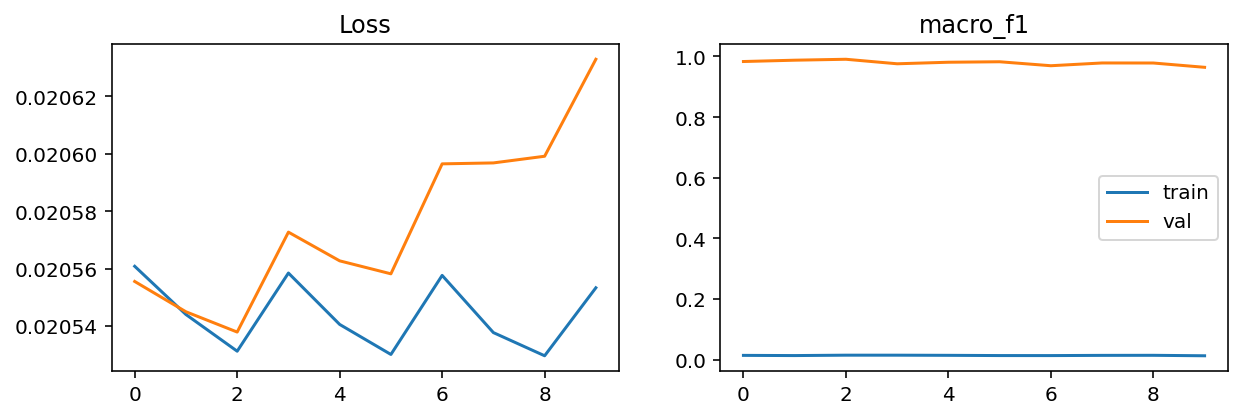

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       605
           1       0.90      1.00      0.95       111
           2       1.00      0.86      0.93       248
           3       0.92      1.00      0.96       561
           4       1.00      0.73      0.84        52
           5       0.85      1.00      0.92       336
           6       0.99      0.92      0.95       218
           7       0.90      0.77      0.83       239
           8       0.98      0.93      0.95       330
           9       1.00      1.00      1.00       289
          10       1.00      1.00      1.00       114
          11       0.96      0.95      0.95       226
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       1.00      0.99      0.99       100
          15       0.99      0.99      0.99       100
          16       1.00      0.99      0.99       100
          17       1.00    

 10%|█         | 1/10 [02:37<23:37, 157.52s/it]

EPOCH 0 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0205  TRAIN_F1 = 0.014 VAL_F1 = 0.989


 20%|██        | 2/10 [05:13<20:55, 156.88s/it]

EPOCH 1 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.988


 30%|███       | 3/10 [07:50<18:16, 156.57s/it]

EPOCH 2 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.014 VAL_F1 = 0.996


 40%|████      | 4/10 [10:27<15:40, 156.70s/it]

EPOCH 3 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.015 VAL_F1 = 0.985


 50%|█████     | 5/10 [13:02<13:00, 156.12s/it]

EPOCH 4 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.013 VAL_F1 = 0.990


 60%|██████    | 6/10 [15:38<10:25, 156.28s/it]

EPOCH 5 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.013 VAL_F1 = 0.993


 70%|███████   | 7/10 [18:14<07:48, 156.19s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.979


 80%|████████  | 8/10 [20:51<05:13, 156.52s/it]

EPOCH 7 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.013 VAL_F1 = 0.983


 90%|█████████ | 9/10 [23:27<02:36, 156.29s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.014 VAL_F1 = 0.990


100%|██████████| 10/10 [26:03<00:00, 156.35s/it]

EPOCH 9 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.012 VAL_F1 = 0.966


train-f1,▇▅▆█▅▅▄▄▅▁
train-loss,█▄▁▇▃▁█▃▁▇
val-f1,▆▆█▆▇▇▄▅▇▁
validation-loss,▃▅▁▄▂▂▆▄▂█
train-f1,0.01211
train-loss,0.02055
val-f1,0.9655
validation-loss,0.02057


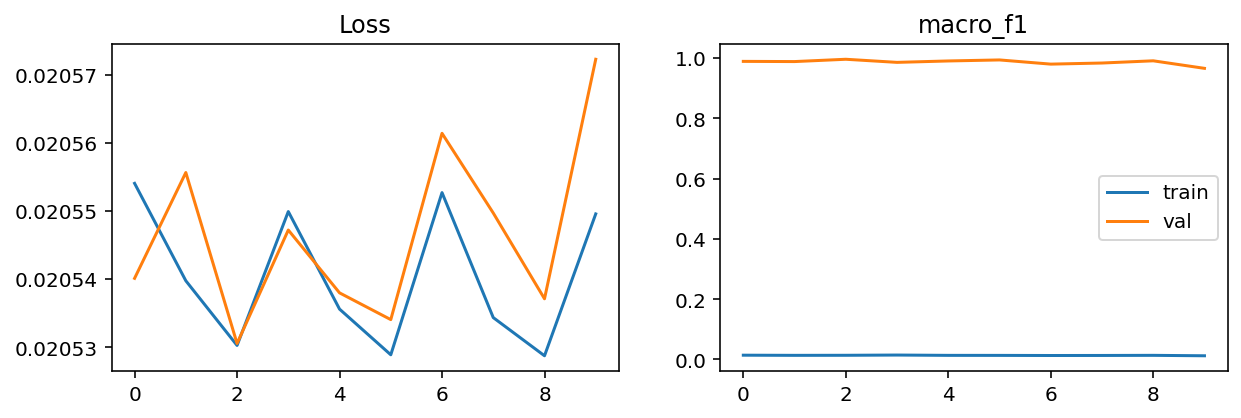

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       605
           1       1.00      1.00      1.00       111
           2       1.00      0.99      0.99       248
           3       1.00      0.95      0.97       608
           4       0.93      0.77      0.84        52
           5       0.98      0.99      0.99       336
           6       1.00      0.99      0.99       218
           7       0.94      1.00      0.97       239
           8       0.99      0.98      0.98       330
           9       1.00      1.00      1.00       289
          10       1.00      1.00      1.00       114
          11       0.97      0.96      0.97       226
          12       1.00      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       0.98      1.00      0.99       100
          15       0.99      0.98      0.98       100
          16       0.99      0.98      0.98       100
          17       0.97    

 10%|█         | 1/10 [02:37<23:34, 157.17s/it]

EPOCH 0 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.013 VAL_F1 = 0.988


 20%|██        | 2/10 [05:12<20:50, 156.32s/it]

EPOCH 1 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.988


 30%|███       | 3/10 [07:49<18:16, 156.63s/it]

EPOCH 2 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0205  TRAIN_F1 = 0.013 VAL_F1 = 0.990


 40%|████      | 4/10 [10:25<15:37, 156.27s/it]

EPOCH 3 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.979


 50%|█████     | 5/10 [13:02<13:02, 156.51s/it]

EPOCH 4 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.986


 60%|██████    | 6/10 [15:38<10:25, 156.42s/it]

EPOCH 5 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.016 VAL_F1 = 0.988


 70%|███████   | 7/10 [18:15<07:49, 156.36s/it]

EPOCH 6 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.978


 80%|████████  | 8/10 [20:52<05:13, 156.82s/it]

EPOCH 7 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.981


 90%|█████████ | 9/10 [23:29<02:36, 156.65s/it]

EPOCH 8 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.985


100%|██████████| 10/10 [26:05<00:00, 156.57s/it]

EPOCH 9 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.966


train-f1,▁▃▁▄▄█▄▃▆▆
train-loss,▇▃▁█▃▁█▃▁▆
val-f1,▇▇█▅▇▇▅▅▆▁
validation-loss,▁▃▁▂▂▂▅▄▃█
train-f1,0.01476
train-loss,0.02054
val-f1,0.96613
validation-loss,0.0206


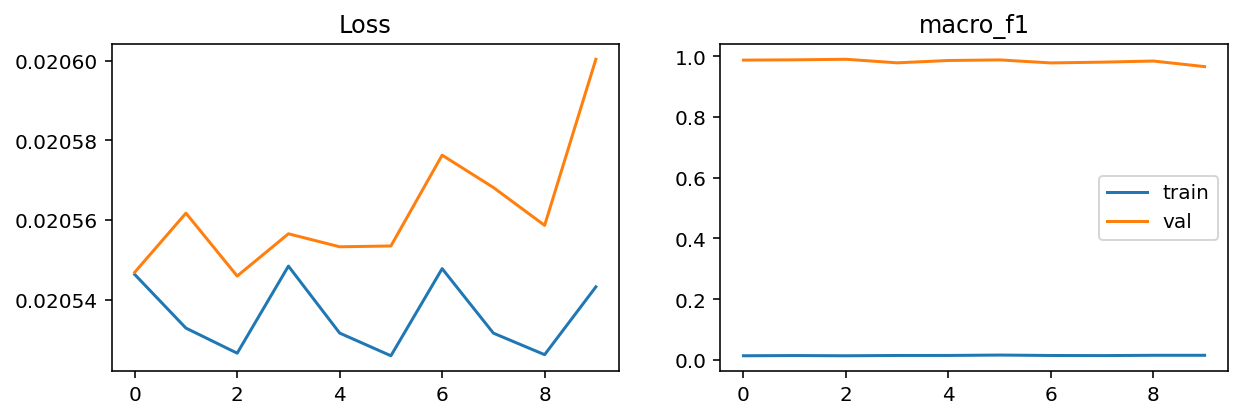

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       605
           1       0.92      0.99      0.96       110
           2       1.00      1.00      1.00       249
           3       1.00      0.85      0.92       608
           4       0.48      1.00      0.65        52
           5       0.99      1.00      0.99       336
           6       1.00      1.00      1.00       218
           7       0.99      0.97      0.98       239
           8       1.00      0.97      0.98       330
           9       1.00      1.00      1.00       289
          10       1.00      1.00      1.00       113
          11       0.98      0.97      0.98       227
          12       0.99      1.00      1.00       100
          13       1.00      1.00      1.00        65
          14       1.00      1.00      1.00       100
          15       0.99      1.00      1.00       100
          16       1.00      1.00      1.00       100
          17       1.00    

In [40]:
run_K_fold(model = 'E', epoch= 10, batch_size = 32, optimizer='AdamW', memo = "K-Fold")

  3%|▎         | 1/30 [04:41<2:16:16, 281.95s/it]

EPOCH 0 : TRAIN_LOSS = 0.0207  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.930


  7%|▋         | 2/30 [09:17<2:09:56, 278.44s/it]

EPOCH 1 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.943


 10%|█         | 3/30 [13:50<2:04:07, 275.84s/it]

EPOCH 2 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.964


 13%|█▎        | 4/30 [18:22<1:58:49, 274.20s/it]

EPOCH 3 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.928


 17%|█▋        | 5/30 [22:55<1:54:04, 273.76s/it]

EPOCH 4 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.016 VAL_F1 = 0.951


 20%|██        | 6/30 [27:31<1:49:48, 274.53s/it]

EPOCH 5 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.961


 23%|██▎       | 7/30 [32:40<1:49:37, 285.97s/it]

EPOCH 6 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.945


 27%|██▋       | 8/30 [37:57<1:48:22, 295.57s/it]

EPOCH 7 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.953


 30%|███       | 9/30 [43:00<1:44:20, 298.10s/it]

EPOCH 8 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.964


 33%|███▎      | 10/30 [47:40<1:37:28, 292.43s/it]

EPOCH 9 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.947


 37%|███▋      | 11/30 [52:18<1:31:11, 287.97s/it]

EPOCH 10 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.952


 40%|████      | 12/30 [56:55<1:25:26, 284.83s/it]

EPOCH 11 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.962


 43%|████▎     | 13/30 [1:01:31<1:19:53, 282.00s/it]

EPOCH 12 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.953


 47%|████▋     | 14/30 [1:06:02<1:14:18, 278.63s/it]

EPOCH 13 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.959


 50%|█████     | 15/30 [1:10:31<1:08:56, 275.75s/it]

EPOCH 14 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.964


 53%|█████▎    | 16/30 [1:14:59<1:03:48, 273.47s/it]

EPOCH 15 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.951


 57%|█████▋    | 17/30 [1:19:29<59:03, 272.58s/it]  

EPOCH 16 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.959


 60%|██████    | 18/30 [1:24:00<54:24, 272.08s/it]

EPOCH 17 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.966


 63%|██████▎   | 19/30 [1:28:34<49:58, 272.59s/it]

EPOCH 18 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.013 VAL_F1 = 0.948


 67%|██████▋   | 20/30 [1:33:11<45:37, 273.72s/it]

EPOCH 19 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.953


 70%|███████   | 21/30 [1:38:10<42:12, 281.40s/it]

EPOCH 20 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.964


 73%|███████▎  | 22/30 [1:43:17<38:33, 289.23s/it]

EPOCH 21 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.954


 77%|███████▋  | 23/30 [1:47:58<33:26, 286.69s/it]

EPOCH 22 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.959


 80%|████████  | 24/30 [1:52:38<28:28, 284.72s/it]

EPOCH 23 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.967


 83%|████████▎ | 25/30 [1:57:17<23:35, 283.04s/it]

EPOCH 24 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.956


 87%|████████▋ | 26/30 [2:01:56<18:46, 281.64s/it]

EPOCH 25 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.962


 90%|█████████ | 27/30 [2:06:35<14:02, 280.86s/it]

EPOCH 26 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.967


 93%|█████████▎| 28/30 [2:11:15<09:21, 280.58s/it]

EPOCH 27 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.955


 97%|█████████▋| 29/30 [2:15:55<04:40, 280.50s/it]

EPOCH 28 : TRAIN_LOSS = 0.0206  VAL_LOSS = 0.0206  TRAIN_F1 = 0.015 VAL_F1 = 0.956


100%|██████████| 30/30 [2:20:36<00:00, 281.20s/it]

EPOCH 29 : TRAIN_LOSS = 0.0205  VAL_LOSS = 0.0206  TRAIN_F1 = 0.014 VAL_F1 = 0.965


train-f1,▃▂▄▅█▄▂▄▅▄▃▃▃▅▂▁▂▆▁▃▃▅▅▆▄▃▆▄▆▃
train-loss,█▄▂▅▃▂▄▂▂▃▂▁▃▂▁▃▂▁▂▂▁▂▂▁▂▂▁▂▁▁
val-f1,▁▄▇▁▅▇▄▅▇▄▅▇▅▇▇▅▆█▅▅▇▆▇█▆▇█▆▆█
validation-loss,█▇▁█▃▁▅▂▁▄▃▁▃▃▁▅▃▁▄▃▁▃▃▁▃▂▁▃▃▁
train-f1,0.0136
train-loss,0.02054
val-f1,0.96525
validation-loss,0.02058


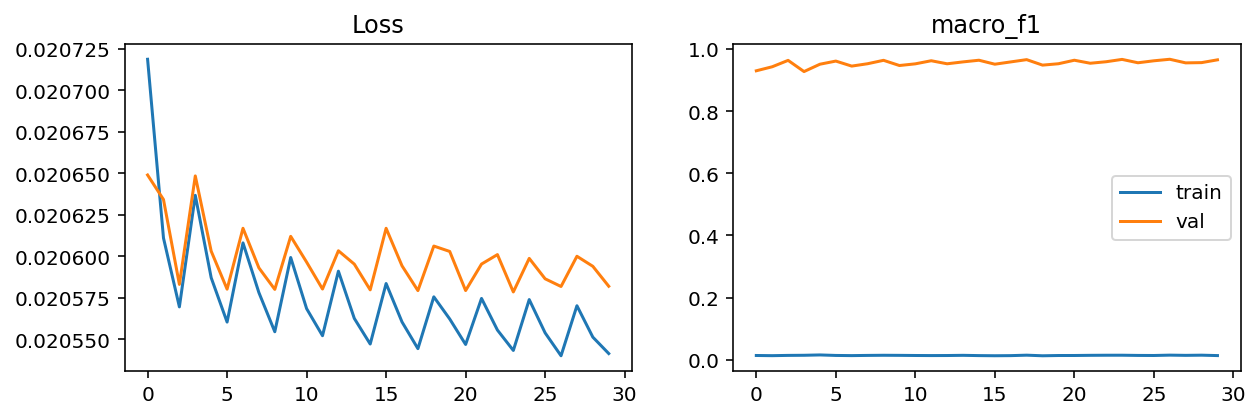

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00       139
           2       1.00      0.99      1.00       311
           3       0.98      0.97      0.97       727
           4       0.81      0.89      0.85        65
           5       1.00      1.00      1.00       420
           6       0.96      1.00      0.98       273
           7       1.00      0.96      0.98       299
           8       1.00      0.99      0.99       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       0.99      0.99      0.99       283
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00        81
          14       0.99      0.99      0.99       125
          15       1.00      0.98      0.99       125
          16       1.00      1.00      1.00       125
          17       1.00    

In [ ]:
run(model = 'E', epoch= 30, batch_size = 32, optimizer='AdamW', memo = "Augmentation")

In [45]:
models = [str(n) + 'th_model.pth' for n in range(5)]

import shutil

# !mkdir /content/kfold1
for model in models:
    src = '/content/' + model
    dst = '/content/kfold1/' + model
    shutil.copy(src, dst)

!mkdir /content/drive/MyDrive/4-1_Capstone/kfold
shutil.make_archive("/content/drive/MyDrive/4-1_Capstone/kfold/kfold1", "zip", "/content/kfold1")

'/content/drive/MyDrive/4-1_Capstone/kfold/kfold1.zip'

In [50]:
from sklearn.model_selection import train_test_split
train_i, val_i, _, _ = train_test_split(list(range(len(label_df))), argmax_classes, stratify=argmax_classes, random_state=0)

train_images = np.array(images)[train_i]
val_images   = np.array(images)[val_i]

train_y = label_df.values[train_i]
val_y   = label_df.values[val_i]

In [51]:
def get_pred(model, val_dataset_info, batch_size = 32):

    test_loader = DataLoader(MyDataset(val_dataset_info, tf, split='VALIDATION'),
                        batch_size=batch_size,
                        shuffle=False,
                        drop_last=False,
                        pin_memory=True,
                        num_workers=4)

    preds = []

    model.eval()
    with torch.no_grad():
        for X, Y in test_loader:
            X = X.to(device)
            Y = Y.to(device)

            H = model(X)
            H *= (torch.eye(N_CLASSES).cuda()[Y.argmax(1)] @ crop_mask)

            preds.extend(H.detach().cpu().numpy().tolist())
    from sklearn.metrics import multilabel_confusion_matrix, classification_report

    # confusion_matrix = multilabel_confusion_matrix(val_y, (preds_numpy > 0).astype(float))

    preds_numpy = np.array(preds)
    preds_sigmoid = (preds_numpy > 0).astype(float)

    cr = classification_report(val_dataset_info[1], preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
    print(cr) # note_that support means count

    return preds

In [55]:
models = []
for i in range(5):
    model = timm.create_model(model_name = 'efficientnet_b0', pretrained=True)
    model.classifier = torch.nn.Linear(in_features=1280, out_features=N_CLASSES, bias=True)
    PATH = f"/content/{i}th_model.pth"
    model.load_state_dict(torch.load(PATH))
    model.eval().cuda()
    models.append(model)

In [56]:
val_dataset_info = (val_images, val_y)
preds = []
for i in range(5):
    pred = test(models[i], val_dataset_info, batch_size = 32)
    preds.append(pred)



              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       0.98      1.00      0.99       139
           2       0.99      0.98      0.98       311
           3       0.98      0.98      0.98       727
           4       0.82      0.92      0.87        65
           5       1.00      1.00      1.00       420
           6       0.87      0.98      0.92       273
           7       1.00      0.86      0.92       299
           8       0.94      1.00      0.97       413
           9       1.00      1.00      1.00       361
          10       0.98      1.00      0.99       142
          11       1.00      0.90      0.95       283
          12       0.99      0.99      0.99       125
          13       0.99      0.95      0.97        81
          14       0.99      1.00      1.00       125
          15       0.98      1.00      0.99       125
          16       1.00      0.99      1.00       125
          17       0.99    

In [63]:
from sklearn.ensemble import VotingClassifier
VC = VotingClassifier(
    estimators=[
    ('model0', models[0]), ('model1', models[1]), ('model2', models[2]), ('model3', models[3]), ('model4', models[4]),
    ],
    voting='soft'
)



In [66]:
pred_ensemble = np.zeros_like(preds[0])

for i in range(5):
    pred_ensemble += np.array(preds[i])

pred_ensemble

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [71]:
(pred_ensemble > 0) * 1

from sklearn.metrics import multilabel_confusion_matrix, classification_report

preds_numpy = np.array(pred_ensemble)
preds_sigmoid = (preds_numpy > 0).astype(float)

cr = classification_report(val_y, preds_sigmoid, output_dict=False, target_names = [str(n) for n in range(len(label_df.columns))])
print(cr) # note_that support means count

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       756
           1       1.00      1.00      1.00       139
           2       1.00      1.00      1.00       311
           3       0.98      0.99      0.98       727
           4       0.91      0.98      0.95        65
           5       1.00      1.00      1.00       420
           6       1.00      1.00      1.00       273
           7       1.00      1.00      1.00       299
           8       1.00      1.00      1.00       413
           9       1.00      1.00      1.00       361
          10       1.00      1.00      1.00       142
          11       1.00      1.00      1.00       283
          12       1.00      1.00      1.00       125
          13       1.00      1.00      1.00        81
          14       1.00      1.00      1.00       125
          15       1.00      1.00      1.00       125
          16       1.00      1.00      1.00       125
          17       1.00    